# Crash emulator 

We want to create an emulator capable of predicting if a parameter dataset will lead to successful or crashed simulation, based on a previous 300 perturbed physics ensemble ran at CNRM. 

#### Emulator equation : Y = f(X) 
* Y is a 1x300 binary matrice Y={0:failed,1:succeeded} containing the list of failed/successed simulations.
* X is a 30X300 matrice containing the 3à values of the hysical parameters, for the 300 perturbations.

## Create emulator : Random Forest

Les forêts d'arbres décisionnels1 (ou forêts aléatoires de l'anglais random forest classifier) ont été premièrement proposées par Ho en 19952 et ont été formellement proposées en 2001 par Leo Breiman et Adèle Cutler. Elles font partie des techniques d'apprentissage automatique. Cet algorithme combine les concepts de sous-espaces aléatoires et de bagging. L'algorithme des forêts d'arbres décisionnels effectue un apprentissage sur de multiples arbres de décision entraînés sur des sous-ensembles de données légèrement différents.

La base du calcul repose sur l'apprentissage par arbre de décision. La proposition de Breiman vise à corriger plusieurs inconvénients connus de la méthode initiale, comme la sensibilité des arbres uniques à l'ordre des prédicteurs, en calculant un ensemble de B arbres partiellement indépendants.

Une présentation rapide de la proposition peut s'exprimer comme suit :

>* Créer B nouveaux ensembles d'apprentissage par un double processus d'échantillonnage :
>>* sur les observations, en utilisant un tirage avec remise d'un nombre N d'observations identique à celui des données d'origine (technique connue sous le nom de bootstrap), 
>>* et sur les p prédicteurs, en n'en retenant qu'un échantillon de cardinal m<sqrt(p) (la limite n'est qu'indicative, elle dépend du paramètre max_features qui est laissé libre de choix à l'utilisateur : des métriques d'erreure out-of-bag et/ou de validation croisée permet d'optimiser ce paramètre).
>* Sur chaque échantillon, on entraîne un arbre de décision selon une des techniques connues, en limitant sa croissance par validation croisée.
>* On stocke les B prédictions de la variable d'intérêt pour chaque observation d'origine.
>* La prédiction de la forêt aléatoire est alors un simple vote majoritaire (Ensemble learning).

Le principal revers de cette méthode est que l'on perd l'aspect visuel des arbres de décision uniques.

### Out-of-bag (OOB) error

The RandomForestClassifier is trained using bootstrap aggregation, where each new tree is fit from a bootstrap sample of the training observations . The out-of-bag (OOB) error is the average error for each  calculated using predictions from the trees that do not contain  in their respective bootstrap sample. This allows the RandomForestClassifier to be fit and validated whilst being trained.

The example below demonstrates how the OOB error can be measured at the addition of each new tree during training. The resulting plot allows a practitioner to approximate a suitable value of n_estimators at which the error stabilizes.

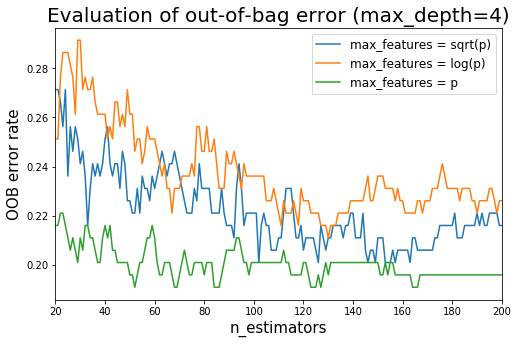

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

# Set the X=inputdata and y=outputdata 
X = np.load(file="inputdata_file.npy")
y_tmp = np.load(file="outputdata_file.npy")
y = y_tmp.ravel()

# split the dataset
X_train = X[0:199,:]
X_test = X[200:249,:]
X_val = X[250:,:]

y_train = y[0:199]
y_test = y[200:249]
y_val = y[250:]

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("max_features = sqrt(p)",
        RandomForestClassifier(warm_start=True, max_depth=4, oob_score=True,
                               max_features="sqrt")),
    ("max_features = log(p)",
        RandomForestClassifier(warm_start=True, max_depth=4, max_features='log2',
                               oob_score=True)),
    ("max_features = p",
        RandomForestClassifier(warm_start=True, max_depth=4, max_features=None,
                               oob_score=True))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 20
max_estimators = 200

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

fig, ax = plt.subplots(figsize=(8,5))
# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators", fontsize = 15)
plt.ylabel("OOB error rate", fontsize = 15)
plt.legend(loc="upper right", fontsize = 12)
plt.title("Evaluation of out-of-bag error (max_depth=4)", fontsize = 20)

#   Enregistrer les figures ...............................................................

plt.savefig("/data/home/globc/peatier/figures/Hyperparameters_tuning_OOB.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

#Show plot 
plt.show()

_Choix du nombre d'arbre : **n_estimators=100** pour atteindre la stabilisation de l'erreur._

Choix du nombre de variables explicatives m tirées aléatoirement parmis les p prédidcteurs :
**max_features=sqrt{p}** pour avoir une OOB error assez faible, décroissante mais pas constante. Le choix de ce paramètre sera malgré tout vérifié par une validation croisée.

### Cross-validation: evaluating estimator performance

Learning the parameters of a prediction function and testing it on the same data is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data. This situation is called overfitting. To avoid it, it is common practice when performing a (supervised) machine learning experiment to hold out part of the available data as a test set X_test, y_test. Note that the word “experiment” is not intended to denote academic use only, because even in commercial settings machine learning usually starts out experimentally. Here is a flowchart of typical cross validation workflow in model training. The best parameters can be determined by grid search techniques.

### Tuning the hyper-parameters of an estimator

Hyper-parameters are parameters that are not directly learnt within estimators. In scikit-learn they are passed as arguments to the constructor of the estimator classes. Typical examples include C, kernel and gamma for Support Vector Classifier, alpha for Lasso, etc.

It is possible and recommended to search the hyper-parameter space for the best cross validation score.

Any parameter provided when constructing an estimator may be optimized in this manner. 

A search consists of:


>* an estimator (regressor or classifier such as sklearn.svm.SVC())
>* a parameter space
>* a method for searching or sampling candidates
>* a cross-validation scheme 
>* a score function

Some models allow for specialized, efficient parameter search strategies, outlined below. Two generic approaches to sampling search candidates are provided in scikit-learn: for given values, GridSearchCV exhaustively considers all parameter combinations, while RandomizedSearchCV can sample a given number of candidates from a parameter space with a specified distribution. After describing these tools we detail best practice applicable to both approaches.

Note that it is common that a small subset of those parameters can have a large impact on the predictive or computation performance of the model while others can be left to their default values. It is recommended to read the docstring of the estimator class to get a finer understanding of their expected behavior, possibly by reading the enclosed reference to the literature.

##### Grid search cross validation

In [51]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

# Set the X=inputdata and y=outputdata 
X = np.load(file="inputdata_file.npy")
y_tmp = np.load(file="outputdata_file.npy")
y = y_tmp.ravel()

# split the dataset
X_train = X[0:199,:]
X_test = X[200:249,:]
X_val = X[250:,:]

y_train = y[0:199]
y_test = y[200:249]
y_val = y[250:]

# Set the parameters by cross-validation
tuned_parameters = [{'max_features' : ['sqrt'], 'max_depth': [2,4,6,8,10]},
                    {'max_features' : ['log2'], 'max_depth': [2,4,6,8,10]},
                    {'max_features' : ['auto'], 'max_depth': [2,4,6,8,10]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        RandomForestClassifier(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'max_depth': 6, 'max_features': 'sqrt'}

Grid scores on development set:

0.806 (+/-0.066) for {'max_depth': 2, 'max_features': 'sqrt'}
0.803 (+/-0.105) for {'max_depth': 4, 'max_features': 'sqrt'}
0.846 (+/-0.096) for {'max_depth': 6, 'max_features': 'sqrt'}
0.809 (+/-0.097) for {'max_depth': 8, 'max_features': 'sqrt'}
0.819 (+/-0.100) for {'max_depth': 10, 'max_features': 'sqrt'}
0.766 (+/-0.129) for {'max_depth': 2, 'max_features': 'log2'}
0.771 (+/-0.134) for {'max_depth': 4, 'max_features': 'log2'}
0.787 (+/-0.136) for {'max_depth': 6, 'max_features': 'log2'}
0.825 (+/-0.163) for {'max_depth': 8, 'max_features': 'log2'}
0.823 (+/-0.091) for {'max_depth': 10, 'max_features': 'log2'}
0.791 (+/-0.105) for {'max_depth': 2, 'max_features': 'auto'}
0.822 (+/-0.092) for {'max_depth': 4, 'max_features': 'auto'}
0.817 (+/-0.117) for {'max_depth': 6, 'max_features': 'auto'}
0.805 (+/-0.125) for {'max_de

##### Set the hyperparameters based on the skill in confusion matrix

In [18]:
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# Set the X=inputdata and y=outputdata 
X = np.load(file="inputdata_file.npy")
y_tmp = np.load(file="outputdata_file.npy")
y=y_tmp.ravel()

# split the dataset
X_train = X[0:199,:]
X_val = X[200:249,:]
X_test = X[250:,:]

y_train = y[0:199]
y_val = y[200:249]
y_test = y[250:]


# we can loop over the n_estimators for different max_depths to construct Random Forests as follows:

#.................... max_depth=2 ...............

depth=2
skill_score_2=[]

i=1
N=201
while i<N: 
    clf = RandomForestClassifier(n_estimators=i,max_depth=depth,max_features='sqrt', bootstrap=True)
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_val)
    cm = confusion_matrix(y_val, y_pred)
    score = ( cm[0,0] + cm[1,1] ) / ( cm[0,0] + cm[0,1] + cm[1,0] + cm[1,1] )
    skill_score_2.append(score)
    i = ( i + 1 )


SkillScore_2=pd.DataFrame(skill_score_2)
skill_2 = SkillScore_2.rename(columns={0: 'skill_score'})
#skill_2

#.................... max_depth=4 ...............

depth=4
skill_score_4=[]

i=1
N=201
while i<N: 
    clf = RandomForestClassifier(n_estimators=i,max_depth=depth,max_features='sqrt', bootstrap=True)
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_val)
    cm = confusion_matrix(y_val, y_pred)
    score = ( cm[0,0] + cm[1,1] ) / ( cm[0,0] + cm[0,1] + cm[1,0] + cm[1,1] )
    skill_score_4.append(score)
    i = ( i + 1 )


SkillScore_4=pd.DataFrame(skill_score_2)
skill_4 = SkillScore_4.rename(columns={0: 'skill_score'})
#skill_4

#.................... max_depth=6 ...............

depth=6
skill_score_6=[]

i=1
N=201
while i<N: 
    clf = RandomForestClassifier(n_estimators=i,max_depth=depth,max_features='sqrt', bootstrap=True)
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_val)
    cm = confusion_matrix(y_val, y_pred)
    score = ( cm[0,0] + cm[1,1] ) / ( cm[0,0] + cm[0,1] + cm[1,0] + cm[1,1] )
    skill_score_6.append(score)
    i = ( i + 1 )


SkillScore_6=pd.DataFrame(skill_score_2)
skill_6 = SkillScore_6.rename(columns={0: 'skill_score'})
#skill_6

#.................... max_depth=8 ...............

depth=8
skill_score_8=[]

i=1
N=201
while i<N: 
    clf = RandomForestClassifier(n_estimators=i,max_depth=depth,max_features='sqrt', bootstrap=True)
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_val)
    cm = confusion_matrix(y_val, y_pred)
    score = ( cm[0,0] + cm[1,1] ) / ( cm[0,0] + cm[0,1] + cm[1,0] + cm[1,1] )
    skill_score_8.append(score)
    i = ( i + 1 )


SkillScore_8=pd.DataFrame(skill_score_2)
skill_8 = SkillScore_8.rename(columns={0: 'skill_score'})
#skill_8


## BUILD the SKILL dataframe
skill_sqrt=pd.DataFrame()
skill_sqrt['n_estimators']=range(1,201,1)
skill_sqrt['skill_score_2']=skill_score_2
skill_sqrt['skill_score_4']=skill_score_4
skill_sqrt['skill_score_6']=skill_score_6
skill_sqrt['skill_score_8']=skill_score_8

skill_sqrt

,n_estimators,skill_score_2,skill_score_4,skill_score_6,skill_score_8
0,1,0.510204,0.816327,0.551020,0.714286
1,2,0.755102,0.571429,0.591837,0.673469
2,3,0.693878,0.714286,0.612245,0.693878
3,4,0.653061,0.755102,0.612245,0.755102
4,5,0.714286,0.714286,0.734694,0.755102
...,...,...,...,...,...
195,196,0.857143,0.836735,0.897959,0.938776
196,197,0.897959,0.918367,0.897959,0.897959
197,198,0.877551,0.897959,0.938776,0.918367
198,199,0.857143,0.897959,0.959184,0.897959


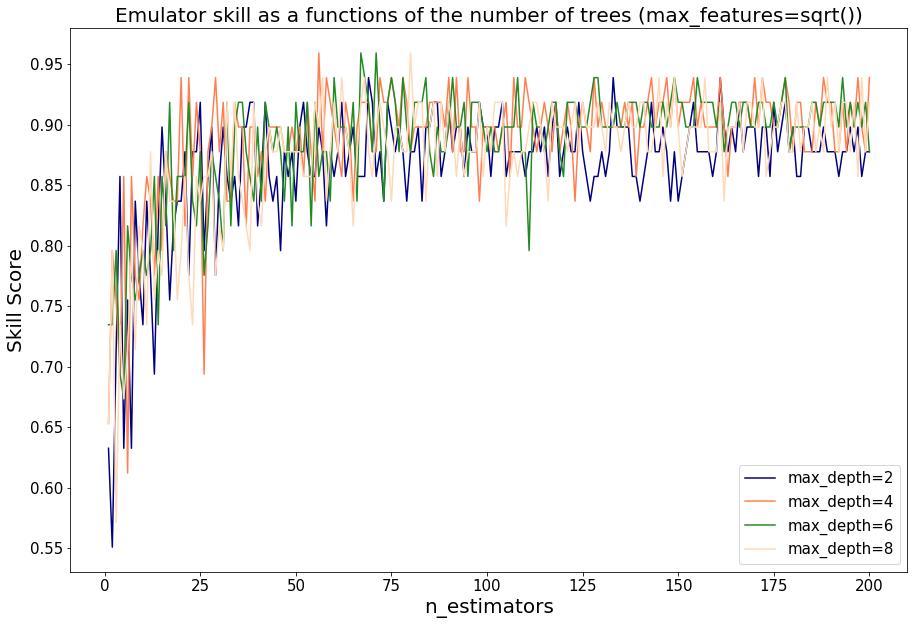

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the skill_score    
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.lineplot(x="n_estimators", y="skill_score_2", data=skill,color='navy',ax=ax)
ax = sns.lineplot(x="n_estimators", y="skill_score_4", data=skill,color='coral',ax=ax)
ax = sns.lineplot(x="n_estimators", y="skill_score_6", data=skill,color='forestgreen',ax=ax)
ax = sns.lineplot(x="n_estimators", y="skill_score_8", data=skill,color='peachpuff',ax=ax)
plt.legend(['max_depth=2','max_depth=4','max_depth=6','max_depth=8'],fontsize=15)
plt.title('Emulator skill as a functions of the number of trees (max_features=sqrt(p))',fontsize=20)
plt.xlabel('n_estimators',fontsize=20)
plt.ylabel('Skill Score',fontsize=20)
ax.tick_params(axis='both', labelsize=15)

#   Enregistrer les figures ...............................................................

plt.savefig("/data/home/globc/peatier/figures/Hyperparameters_tuning_sqrt.png", dpi=None, 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show plot 
plt.show()

In [22]:
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# Set the X=inputdata and y=outputdata 
X = np.load(file="inputdata_file.npy")
y_tmp = np.load(file="outputdata_file.npy")
y=y_tmp.ravel()

# split the dataset
X_train = X[0:199,:]
X_val = X[200:249,:]
X_test = X[250:,:]

y_train = y[0:199]
y_val = y[200:249]
y_test = y[250:]


# we can loop over the n_estimators for different max_depths to construct Random Forests as follows:

#.................... max_depth=2 ...............

depth=2
skill_score_2=[]

i=1
N=201
while i<N: 
    clf = RandomForestClassifier(n_estimators=i,max_depth=depth,max_features='log2', bootstrap=True)
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_val)
    cm = confusion_matrix(y_val, y_pred)
    score = ( cm[0,0] + cm[1,1] ) / ( cm[0,0] + cm[0,1] + cm[1,0] + cm[1,1] )
    skill_score_2.append(score)
    i = ( i + 1 )


SkillScore_2=pd.DataFrame(skill_score_2)
skill_2 = SkillScore_2.rename(columns={0: 'skill_score'})
#skill_2

#.................... max_depth=4 ...............

depth=4
skill_score_4=[]

i=1
N=201
while i<N: 
    clf = RandomForestClassifier(n_estimators=i,max_depth=depth,max_features='log2', bootstrap=True)
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_val)
    cm = confusion_matrix(y_val, y_pred)
    score = ( cm[0,0] + cm[1,1] ) / ( cm[0,0] + cm[0,1] + cm[1,0] + cm[1,1] )
    skill_score_4.append(score)
    i = ( i + 1 )


SkillScore_4=pd.DataFrame(skill_score_2)
skill_4 = SkillScore_4.rename(columns={0: 'skill_score'})
#skill_4

#.................... max_depth=6 ...............

depth=6
skill_score_6=[]

i=1
N=201
while i<N: 
    clf = RandomForestClassifier(n_estimators=i,max_depth=depth,max_features='log2', bootstrap=True)
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_val)
    cm = confusion_matrix(y_val, y_pred)
    score = ( cm[0,0] + cm[1,1] ) / ( cm[0,0] + cm[0,1] + cm[1,0] + cm[1,1] )
    skill_score_6.append(score)
    i = ( i + 1 )


SkillScore_6=pd.DataFrame(skill_score_2)
skill_6 = SkillScore_6.rename(columns={0: 'skill_score'})
#skill_6

#.................... max_depth=8 ...............

depth=8
skill_score_8=[]

i=1
N=201
while i<N: 
    clf = RandomForestClassifier(n_estimators=i,max_depth=depth,max_features='log2', bootstrap=True)
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_val)
    cm = confusion_matrix(y_val, y_pred)
    score = ( cm[0,0] + cm[1,1] ) / ( cm[0,0] + cm[0,1] + cm[1,0] + cm[1,1] )
    skill_score_8.append(score)
    i = ( i + 1 )


SkillScore_8=pd.DataFrame(skill_score_2)
skill_8 = SkillScore_8.rename(columns={0: 'skill_score'})
#skill_8


## BUILD the SKILL dataframe
skill_log=pd.DataFrame()
skill_log['n_estimators']=range(1,201,1)
skill_log['skill_score_2']=skill_score_2
skill_log['skill_score_4']=skill_score_4
skill_log['skill_score_6']=skill_score_6
skill_log['skill_score_8']=skill_score_8

skill_log

,n_estimators,skill_score_2,skill_score_4,skill_score_6,skill_score_8
0,1,0.469388,0.714286,0.551020,0.653061
1,2,0.693878,0.755102,0.693878,0.755102
2,3,0.775510,0.612245,0.693878,0.612245
3,4,0.551020,0.795918,0.734694,0.673469
4,5,0.693878,0.775510,0.775510,0.673469
...,...,...,...,...,...
195,196,0.836735,0.877551,0.877551,0.897959
196,197,0.857143,0.918367,0.877551,0.877551
197,198,0.836735,0.918367,0.877551,0.897959
198,199,0.877551,0.877551,0.959184,0.877551


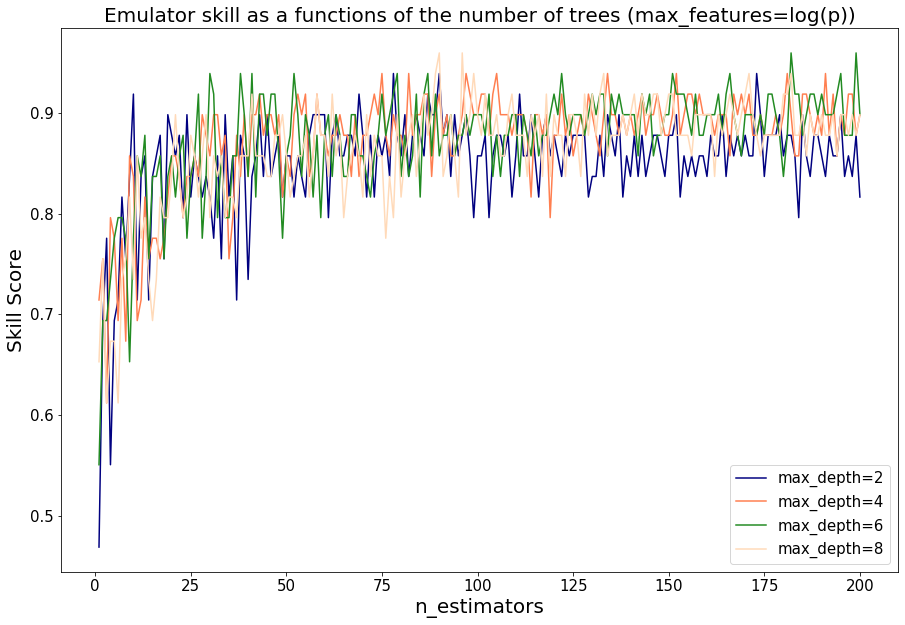

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the skill_score    
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.lineplot(x="n_estimators", y="skill_score_2", data=skill_log,color='navy',ax=ax)
ax = sns.lineplot(x="n_estimators", y="skill_score_4", data=skill_log,color='coral',ax=ax)
ax = sns.lineplot(x="n_estimators", y="skill_score_6", data=skill_log,color='forestgreen',ax=ax)
ax = sns.lineplot(x="n_estimators", y="skill_score_8", data=skill_log,color='peachpuff',ax=ax)
plt.legend(['max_depth=2','max_depth=4','max_depth=6','max_depth=8'],fontsize=15)
plt.title('Emulator skill as a functions of the number of trees (max_features=log(p))',fontsize=20)
plt.xlabel('n_estimators',fontsize=20)
plt.ylabel('Skill Score',fontsize=20)
ax.tick_params(axis='both', labelsize=15)

#   Enregistrer les figures ...............................................................

plt.savefig("/data/home/globc/peatier/figures/Hyperparameters_tuning_log.png", dpi=None, 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show plot 
plt.show()

In [3]:
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# Set the X=inputdata and y=outputdata 
X = np.load(file="inputdata_file.npy")
y_tmp = np.load(file="outputdata_file.npy")
y=y_tmp.ravel()

# split the dataset
X_train = X[0:199,:]
X_val = X[200:249,:]
X_test = X[250:,:]

y_train = y[0:199]
y_val = y[200:249]
y_test = y[250:]


# we can loop over the n_estimators for different max_depths to construct Random Forests as follows:

#.................... max_depth=2 ...............

depth=2
skill_score_2=[]

i=1
N=201
while i<N: 
    clf = RandomForestClassifier(n_estimators=i,max_depth=depth,max_features=None, bootstrap=True)
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_val)
    cm = confusion_matrix(y_val, y_pred)
    score = ( cm[0,0] + cm[1,1] ) / ( cm[0,0] + cm[0,1] + cm[1,0] + cm[1,1] )
    skill_score_2.append(score)
    i = ( i + 1 )


SkillScore_2=pd.DataFrame(skill_score_2)
skill_2 = SkillScore_2.rename(columns={0: 'skill_score'})
#skill_2

#.................... max_depth=4 ...............

depth=4
skill_score_4=[]

i=1
N=201
while i<N: 
    clf = RandomForestClassifier(n_estimators=i,max_depth=depth,max_features=None, bootstrap=True)
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_val)
    cm = confusion_matrix(y_val, y_pred)
    score = ( cm[0,0] + cm[1,1] ) / ( cm[0,0] + cm[0,1] + cm[1,0] + cm[1,1] )
    skill_score_4.append(score)
    i = ( i + 1 )


SkillScore_4=pd.DataFrame(skill_score_2)
skill_4 = SkillScore_4.rename(columns={0: 'skill_score'})
#skill_4

#.................... max_depth=6 ...............

depth=6
skill_score_6=[]

i=1
N=201
while i<N: 
    clf = RandomForestClassifier(n_estimators=i,max_depth=depth,max_features=None, bootstrap=True)
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_val)
    cm = confusion_matrix(y_val, y_pred)
    score = ( cm[0,0] + cm[1,1] ) / ( cm[0,0] + cm[0,1] + cm[1,0] + cm[1,1] )
    skill_score_6.append(score)
    i = ( i + 1 )


SkillScore_6=pd.DataFrame(skill_score_2)
skill_6 = SkillScore_6.rename(columns={0: 'skill_score'})
#skill_6

#.................... max_depth=8 ...............

depth=8
skill_score_8=[]

i=1
N=201
while i<N: 
    clf = RandomForestClassifier(n_estimators=i,max_depth=depth,max_features=None, bootstrap=True)
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_val)
    cm = confusion_matrix(y_val, y_pred)
    score = ( cm[0,0] + cm[1,1] ) / ( cm[0,0] + cm[0,1] + cm[1,0] + cm[1,1] )
    skill_score_8.append(score)
    i = ( i + 1 )


SkillScore_8=pd.DataFrame(skill_score_2)
skill_8 = SkillScore_8.rename(columns={0: 'skill_score'})
#skill_8


## BUILD the SKILL dataframe
skill_p=pd.DataFrame()
skill_p['n_estimators']=range(1,201,1)
skill_p['skill_score_2']=skill_score_2
skill_p['skill_score_4']=skill_score_4
skill_p['skill_score_6']=skill_score_6
skill_p['skill_score_8']=skill_score_8

skill_p

,n_estimators,skill_score_2,skill_score_4,skill_score_6,skill_score_8
0,1,0.857143,0.857143,0.734694,0.653061
1,2,0.877551,0.775510,0.775510,0.857143
2,3,0.918367,0.816327,0.816327,0.816327
3,4,0.918367,0.816327,0.836735,0.714286
4,5,0.918367,0.836735,0.755102,0.836735
...,...,...,...,...,...
195,196,0.897959,0.938776,0.918367,0.938776
196,197,0.897959,0.938776,0.938776,0.938776
197,198,0.897959,0.938776,0.918367,0.938776
198,199,0.897959,0.938776,0.938776,0.918367


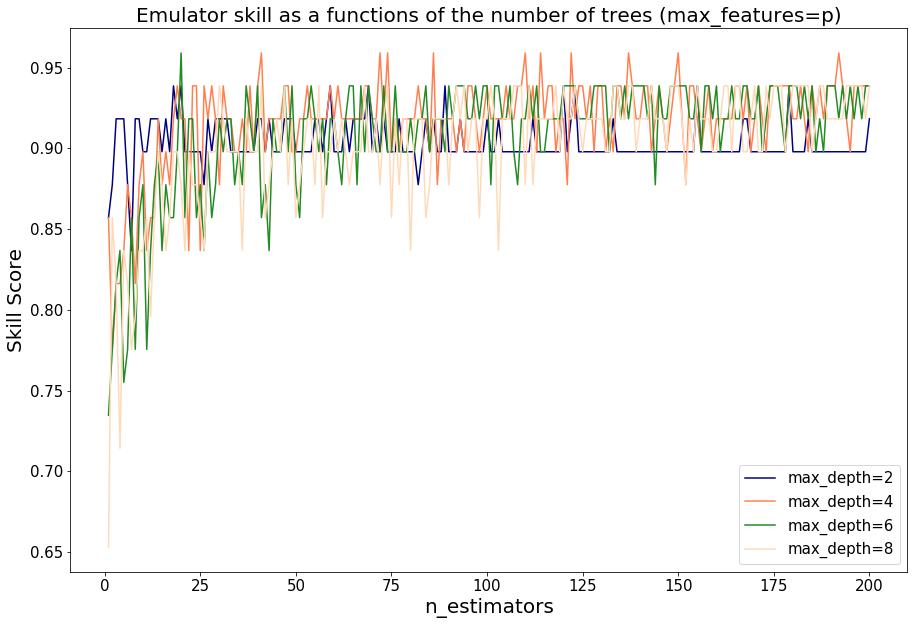

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the skill_score    
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.lineplot(x="n_estimators", y="skill_score_2", data=skill_p,color='navy',ax=ax)
ax = sns.lineplot(x="n_estimators", y="skill_score_4", data=skill_p,color='coral',ax=ax)
ax = sns.lineplot(x="n_estimators", y="skill_score_6", data=skill_p,color='forestgreen',ax=ax)
ax = sns.lineplot(x="n_estimators", y="skill_score_8", data=skill_p,color='peachpuff',ax=ax)
plt.legend(['max_depth=2','max_depth=4','max_depth=6','max_depth=8'],fontsize=15)
plt.title('Emulator skill as a functions of the number of trees (max_features=p)',fontsize=20)
plt.xlabel('n_estimators',fontsize=20)
plt.ylabel('Skill Score',fontsize=20)
ax.tick_params(axis='both', labelsize=15)

#   Enregistrer les figures ...............................................................

plt.savefig("/data/home/globc/peatier/figures/Hyperparameters_tuning_p.png", dpi=None, 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show plot 
plt.show()

It seems that we only need **n_estimators=50** trees to reach a very acceptable skill score. The max_depth of the trees do not matter a lot, even if 2 layers seem a bit low. we can probably agree on max_depth=4.

### Create Random Forest

In [75]:
import numpy as np
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

# Set the X=inputdata and y=outputdata 
X = np.load(file="inputdata_file.npy")
y_tmp = np.load(file="outputdata_file.npy")
y=y_tmp.ravel()

# split the dataset
X_train = X[0:199,:]
X_test = X[200:249,:]
X_val = X[250:,:]

y_train = y[0:199]
y_test = y[200:249]
y_val = y[250:]


# we can construct a Random Forest as follows:

clf = RandomForestClassifier(n_estimators=50,max_depth=4,max_features='sqrt', bootstrap=True)
clf = clf.fit(X_train,y_train)

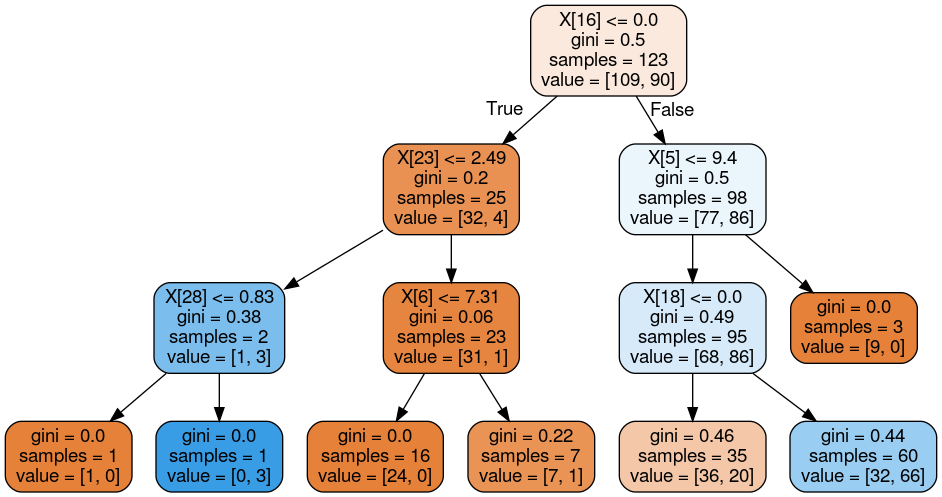

In [21]:
#.............. To vizualise a single tree of the forest .............

# Extract single tree
estimator = clf.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot',
                rounded = True, proportion = False, 
                precision = 2, filled = True)

import pydot

(graph,) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

In [2]:
# Definition d'une fonction Matrice de Confusion pour aider la visualisation de la qualité des données prédites 
# comparé aux données de léchantillon test.

import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
#    “”"
#    This function prints and plots the confusion matrix.
#    Normalization can be applied by setting `normalize=True`.
#    “”"
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(len(classes)-2),
           yticks=np.arange(len(classes)-2),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes)
    ax.set_title(title, pad=30, fontsize=15)
    ax.set_xlabel('Predicted label', labelpad=65, fontsize=18)
    ax.set_ylabel('True label', labelpad=65, fontsize=18)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right',
             rotation_mode='anchor')
    plt.setp(ax.get_yticklabels(), rotation=45, ha='right', va='center',
             rotation_mode='anchor')
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(len(classes)):
        ax.text(-0.7,i,classes[i],color='black',rotation=45, fontsize=13)
        ax.text(i,1.7,classes[i],color='black',rotation=45, fontsize=13)        
        for j in range(len(classes)):
            ax.text(j, i, cm[i, j],
                    ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black', fontsize=15)
            
    fig.tight_layout()
    return ax

Confusion matrix, without normalization


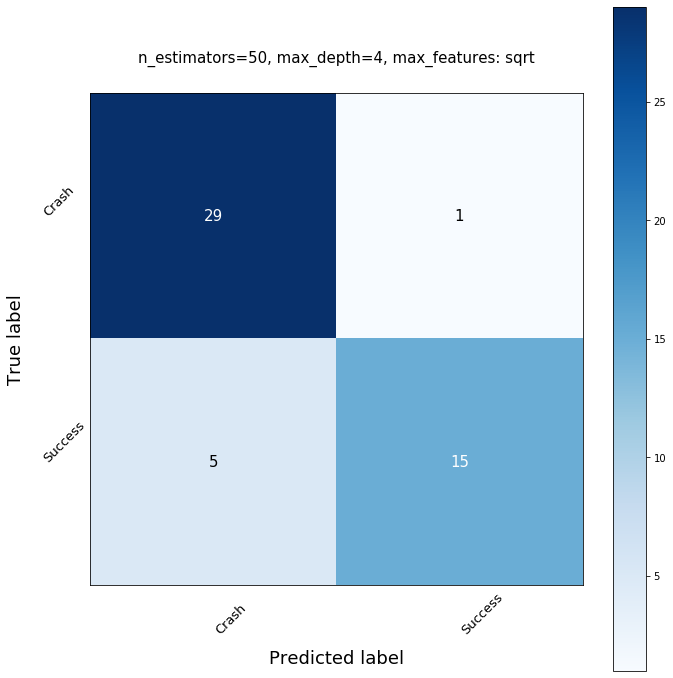

In [78]:
# Predict 
y_pred = clf.predict(X_val)
y_pred

# Appel de la fonction confusion matrix
classes=['Crash', 'Success']

plot_confusion_matrix(y_val, y_pred, classes, normalize=False, 
                      title='n_estimators=50, max_depth=4, max_features: sqrt')

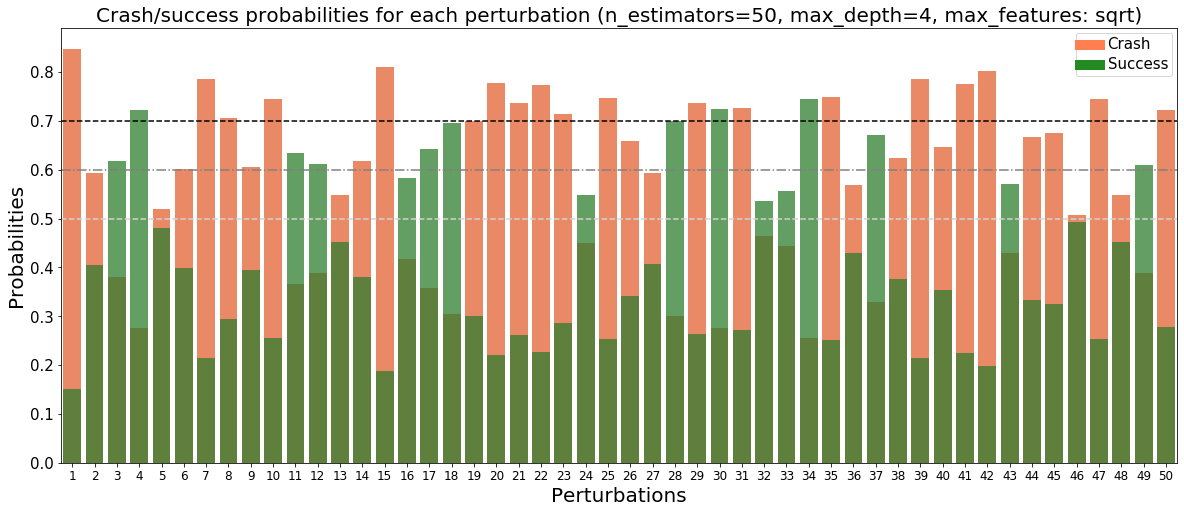

In [81]:
import pandas as pd
import seaborn as sns

# Predict Proba
y_proba_pred = clf.predict_proba(X_val)
y_proba_pred = pd.DataFrame(y_proba_pred)
y_proba_pred['Pertubations']=range(1,51,1)
y_proba_pred = y_proba_pred.rename(columns={0: 'Crash', 1:'Success'})
y_proba_pred

# Plot
fig, ax = plt.subplots(figsize=(20,8))
ax = sns.barplot(x='Pertubations',y='Crash',data=y_proba_pred, color='coral', ax=ax)
ax = sns.barplot(x='Pertubations',y='Success',data=y_proba_pred, color='forestgreen',alpha=0.75, ax=ax)

ax.axhline(0.5, ls='--', color='lightgray')
ax.axhline(0.6, ls='-.', color='gray')
ax.axhline(0.7, ls='--', color='black')

plt.legend(['Crash', 'Success'])
plt.title('Crash/success probabilities for each perturbation (n_estimators=50, max_depth=4, max_features: sqrt)', fontsize=20)
plt.xlabel('Perturbations', fontsize=20)
plt.ylabel('Probabilities', fontsize=20)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=12)
leg = ax.get_legend()
leg.legendHandles[0].set_color('coral')
leg.legendHandles[1].set_color('forestgreen')

for label in leg.get_texts():
    label.set_fontsize(15)

for label in leg.get_lines():
    label.set_linewidth(10)  # the legend line width
    
plt.show()

## Use emulator to study the parameters

We want to see which smpling lead to a crash, in reality and in the emulator.

In [18]:
# Definition d'une fonction Matrice de Confusion pour aider la visualisation de la qualité des données prédites 
# comparé aux données de léchantillon test.

import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
#    “”"
#    This function prints and plots the confusion matrix.
#    Normalization can be applied by setting `normalize=True`.
#    “”"
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(len(classes)-2),
           yticks=np.arange(len(classes)-2),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes)
    ax.set_title(title, pad=30, fontsize=15)
    ax.set_xlabel('Predicted label', labelpad=65, fontsize=18)
    ax.set_ylabel('True label', labelpad=65, fontsize=18)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right',
             rotation_mode='anchor')
    plt.setp(ax.get_yticklabels(), rotation=45, ha='right', va='center',
             rotation_mode='anchor')
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(len(classes)):
        ax.text(-0.7,i,classes[i],color='black',rotation=45, fontsize=13)
        ax.text(i,1.7,classes[i],color='black',rotation=45, fontsize=13)        
        for j in range(len(classes)):
            ax.text(j, i, cm[i, j],
                    ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black', fontsize=15)
            
    fig.tight_layout()
    return ax

In [57]:
# Build an train emulator: 

import numpy as np
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

# Set the X=inputdata and y=outputdata 
X = np.load(file="inputdata_file.npy")
y_tmp = np.load(file="outputdata_file.npy")
y=y_tmp.ravel()

# split the dataset
X_train = X[0:199,:]
X_test = X[200:,:]

y_train = y[0:199]
y_test = y[200:]


# we can construct a Random Forest as follows:

clf = RandomForestClassifier(n_estimators=50,max_depth=4,max_features='sqrt', bootstrap=True)
clf = clf.fit(X_train,y_train)

Confusion matrix, without normalization


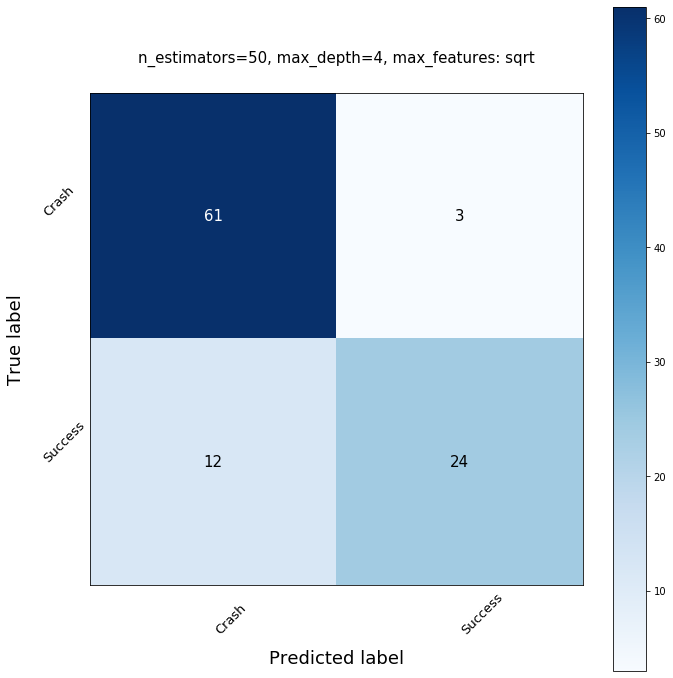

In [58]:
# Predict 
y_pred = clf.predict(X_test)
y_pred

# Appel de la fonction confusion matrix
classes=['Crash', 'Success']

plot_confusion_matrix(y_test, y_pred, classes, normalize=False, 
                      title='n_estimators=50, max_depth=4, max_features: sqrt')

In [59]:
import pandas as pd
import seaborn as sns

# Predict Proba
y_proba_pred = clf.predict_proba(X_test)
y_proba_pred = pd.DataFrame(y_proba_pred)
y_proba_pred['Pertubations']=range(1,101,1)
y_proba_pred = y_proba_pred.rename(columns={0: 'Crash', 1:'Success'})
y_proba_pred

,Crash,Success,Pertubations
0,0.313779,0.686221,1
1,0.623353,0.376647,2
2,0.529437,0.470563,3
3,0.811528,0.188472,4
4,0.679362,0.320638,5
...,...,...,...
95,0.455388,0.544612,96
96,0.864766,0.135234,97
97,0.530469,0.469531,98
98,0.364570,0.635430,99


In [60]:
y_pred_crash=pd.DataFrame(y_pred)
y_pred_crash = y_pred_crash.rename(columns={0: 'class'})

y_pred=pd.DataFrame()
y_pred['class']=y_pred_crash['class']
y_pred['proba']=range(1,101,1)

i=0
while i<len(y_proba_pred):
    tmp=y_proba_pred.iloc[i]
    if tmp['Crash']>tmp['Success']:
        y_pred['proba'].iloc[i]=tmp['Crash']
    else :
        y_pred['proba'].iloc[i]=tmp['Success']
    i = ( i + 1 )

y_pred['Perturbations']=range(1,101,1)
y_pred

/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,class,proba,Perturbations
0,1,0.686221,1
1,0,0.623353,2
2,0,0.529437,3
3,0,0.811528,4
4,0,0.679362,5
...,...,...,...
95,1,0.544612,96
96,0,0.864766,97
97,0,0.530469,98
98,1,0.635430,99


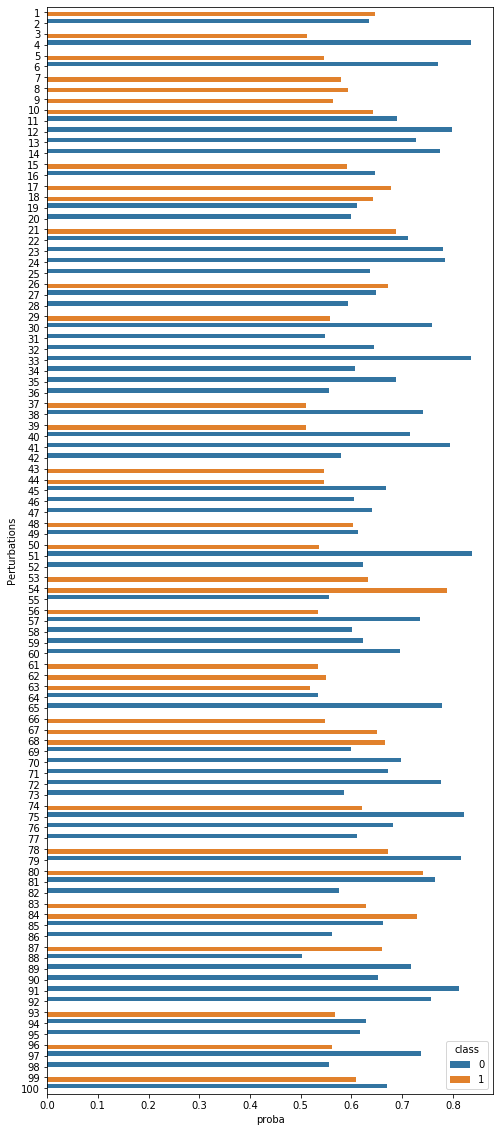

In [71]:
fig, ax = plt.subplots(figsize=(8,20))
ax = sns.barplot(x="proba", y="Perturbations", hue="class", data=y_pred, orient='h')
plt.show()

In [61]:
y_PRED=pd.DataFrame()
y_PRED['class']=range(1,201,1)
y_PRED['proba']=range(1,201,1)

frames=[y_PRED,y_pred]
pred = pd.concat(frames,ignore_index=True)
pred.iloc[0:199]=np.NaN
pred

/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,Perturbations,class,proba
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
295,96.0,1.0,0.544612
296,97.0,0.0,0.864766
297,98.0,0.0,0.530469
298,99.0,1.0,0.635430


In [1]:
import numpy as np
import pandas as pd

data = pd.read_csv("./input.csv",sep=' ')
inputdata=data.drop(['t_IDs'],axis=1)

# Set the X=inputdata and y=outputdata 
y_tmp = np.load(file="outputdata_file.npy")
y_true=y_tmp.ravel()
#y_true
inputdata['y_true']=y_true
inputdata['y_pred_class']=pred['class']
inputdata['y_pred_proba']=pred['proba']

# Loop to construct new column gathering true and predicted data
Y=[]
i=0
N=len(inputdata)
while i<N:
    tmp=inputdata.iloc[i]
    if tmp['y_true']==0:
        if tmp['y_pred_class']==0:
            Y.append(0.0)
        else :
            Y.append(0.1)
    else :
        if tmp['y_pred_class']==0:
            Y.append(1.0)
        else :
            Y.append(1.1)
    i=(i+1)

inputdata['Y']=Y
            
# Save the parameters names in a list 
param_names=list(inputdata.columns.values)
#param_names

inputdata

NameError: name 'pred' is not defined

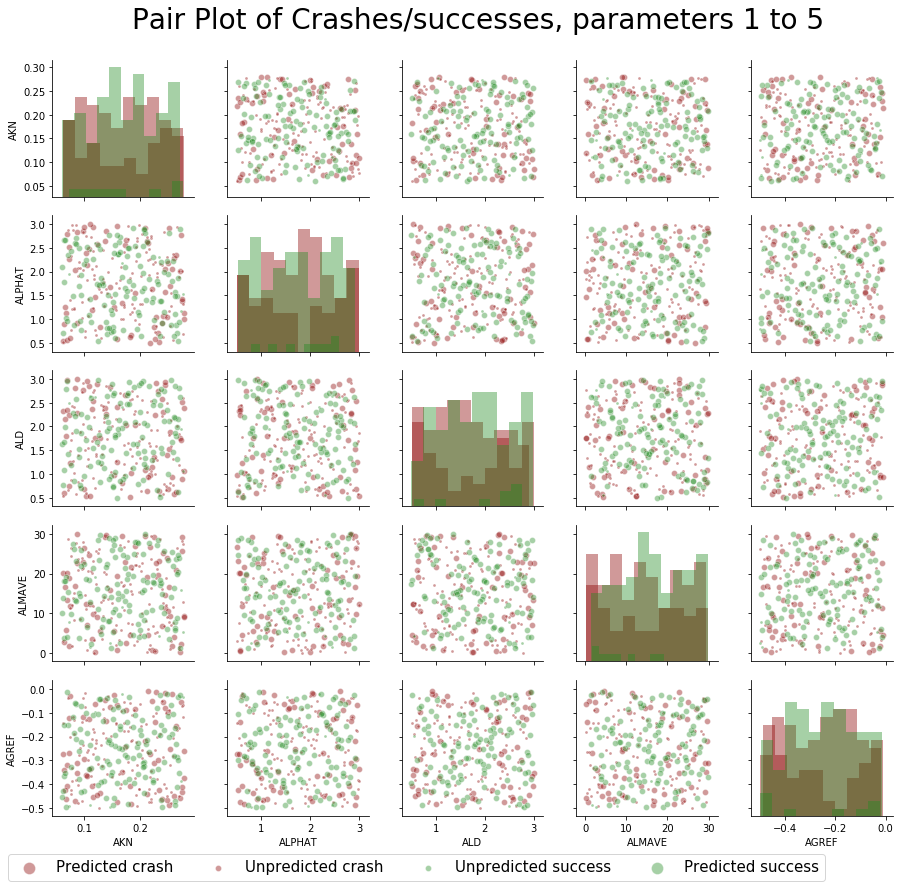

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Pair plot
g = sns.pairplot(inputdata[['AKN', 'ALPHAT', 'ALD', 'ALMAVE', 'AGREF','Y']], hue='Y',markers=["o",".",".","o"],
            palette=('darkred','darkred','forestgreen','forestgreen'),vars=['AKN', 'ALPHAT', 'ALD', 'ALMAVE', 'AGREF'], 
                 diag_kind='hist', diag_kws = {'alpha': 0.4},plot_kws = {'alpha': 0.4})

handles = g._legend_data.values()
labels = g._legend_data.keys()
g._legend.remove()
g.fig.legend(handles=handles, 
             labels=['Predicted crash','Unpredicted crash','Unpredicted success','Predicted success' ], 
             loc='lower left', ncol=5, fontsize=15, markerscale=2)
g.fig.subplots_adjust(top=0.92, bottom=0.08)

# Title 
plt.suptitle('Pair plot of Crashes/successes, parameters 1 to 5', 
             size = 28)

plt.show()

In [42]:
# Definition d'une fonction pour un meilleur scattering (problème d'échelle sur l'axe y dans sns.pairplot)
def better_scatter(x, y, **kwargs):
    sns.scatterplot(x, y, **kwargs, alpha=0.2)
    margin = (max(y) - min(y)) * 0.1
    plt.ylim(min(y) - margin, max(y) + margin)

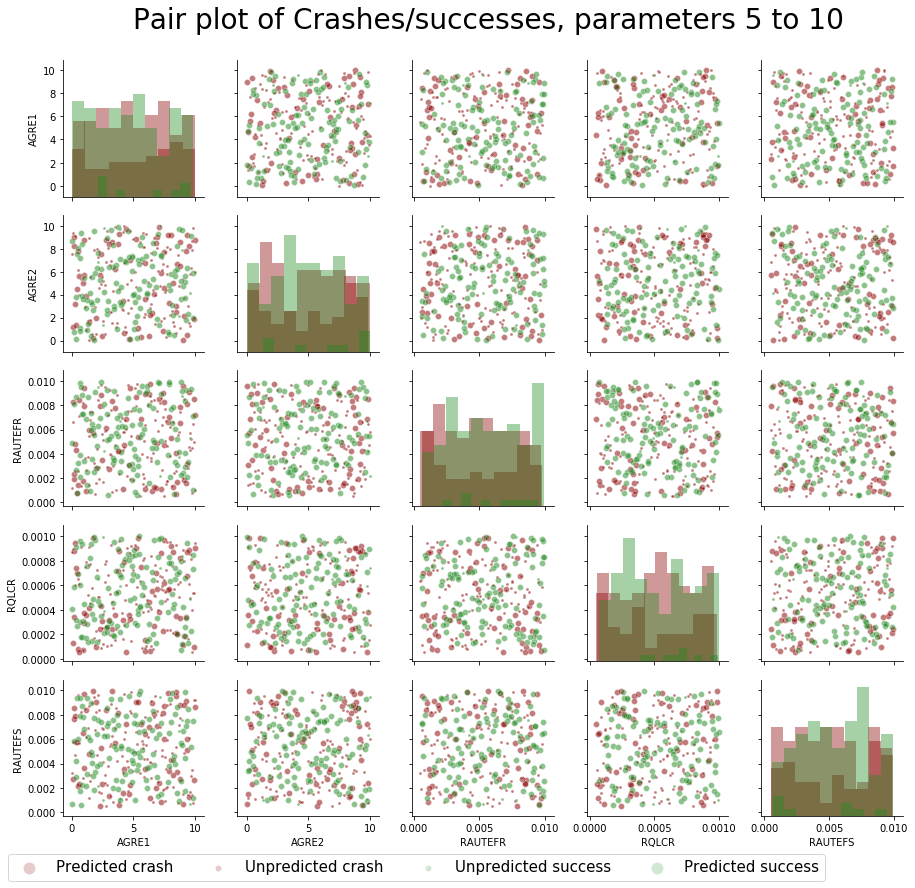

In [43]:
# Pair plot

g = sns.pairplot(inputdata[['AGRE1',
 'AGRE2',
 'RAUTEFR',
 'RQLCR',
 'RAUTEFS','Y']], hue='Y',markers=["o",".",".","o"],
            palette=('darkred','darkred','forestgreen','forestgreen'),vars=['AGRE1',
 'AGRE2',
 'RAUTEFR',
 'RQLCR',
 'RAUTEFS'], diag_kind='hist', diag_kws = {'alpha': 0.4}, plot_kws = {'alpha': 0.4})

g = g.map_offdiag(better_scatter)

handles = g._legend_data.values()
labels = g._legend_data.keys()
g._legend.remove()
g.fig.legend(handles=handles, 
             labels=['Predicted crash','Unpredicted crash','Unpredicted success','Predicted success' ],
             loc='lower left', ncol=5, fontsize=15, markerscale=2)
g.fig.subplots_adjust(top=0.92, bottom=0.08)

# Title 
plt.suptitle('Pair plot of Crashes/successes, parameters 5 to 10', 
             size = 28)
    
plt.show()

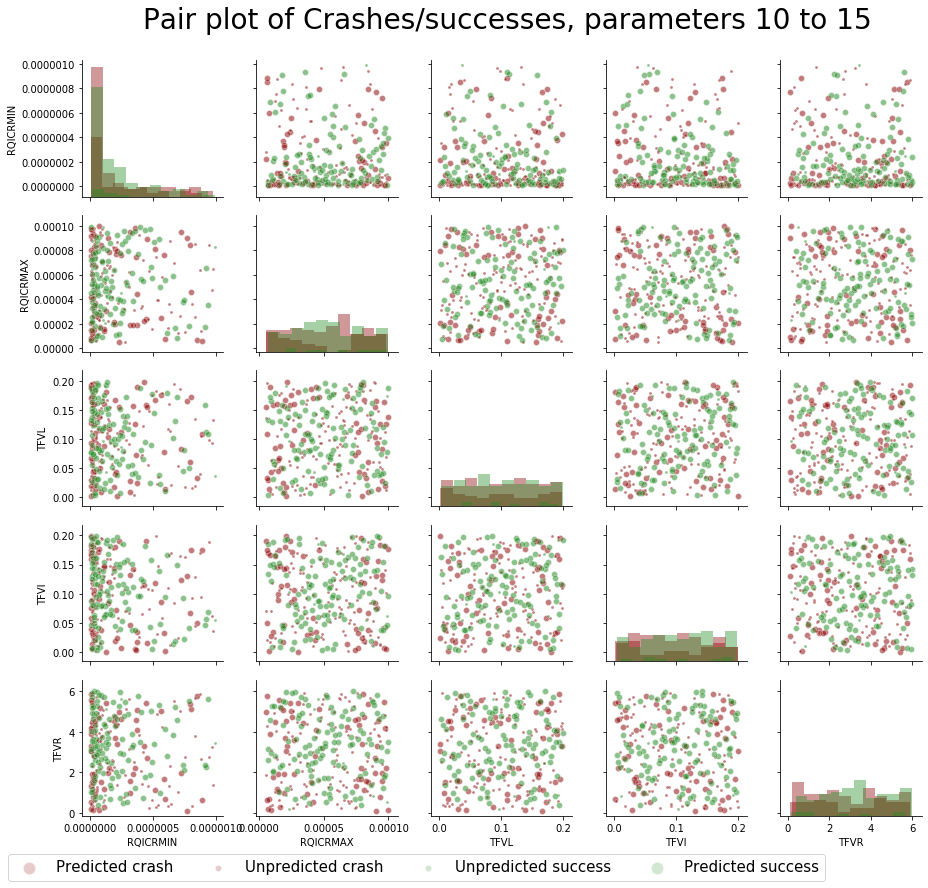

In [44]:
# Pair plot

g = sns.pairplot(inputdata[['RQICRMIN',
 'RQICRMAX',
 'TFVL',
 'TFVI',
 'TFVR','Y']], hue='Y',markers=["o",".",".","o"],
            palette=('darkred','darkred','forestgreen','forestgreen'),vars=['RQICRMIN',
 'RQICRMAX',
 'TFVL',
 'TFVI',
 'TFVR'], diag_kind='hist', diag_kws = {'alpha': 0.4}, plot_kws = {'alpha': 0.4})

g = g.map_offdiag(better_scatter)

handles = g._legend_data.values()
labels = g._legend_data.keys()
g._legend.remove()
g.fig.legend(handles=handles, 
             labels=['Predicted crash','Unpredicted crash','Unpredicted success','Predicted success' ],
             loc='lower left', ncol=5, fontsize=15, markerscale=2)
g.fig.subplots_adjust(top=0.92, bottom=0.08)

# Title 
plt.suptitle('Pair plot of Crashes/successes, parameters 10 to 15', 
             size = 28)
    
plt.show()

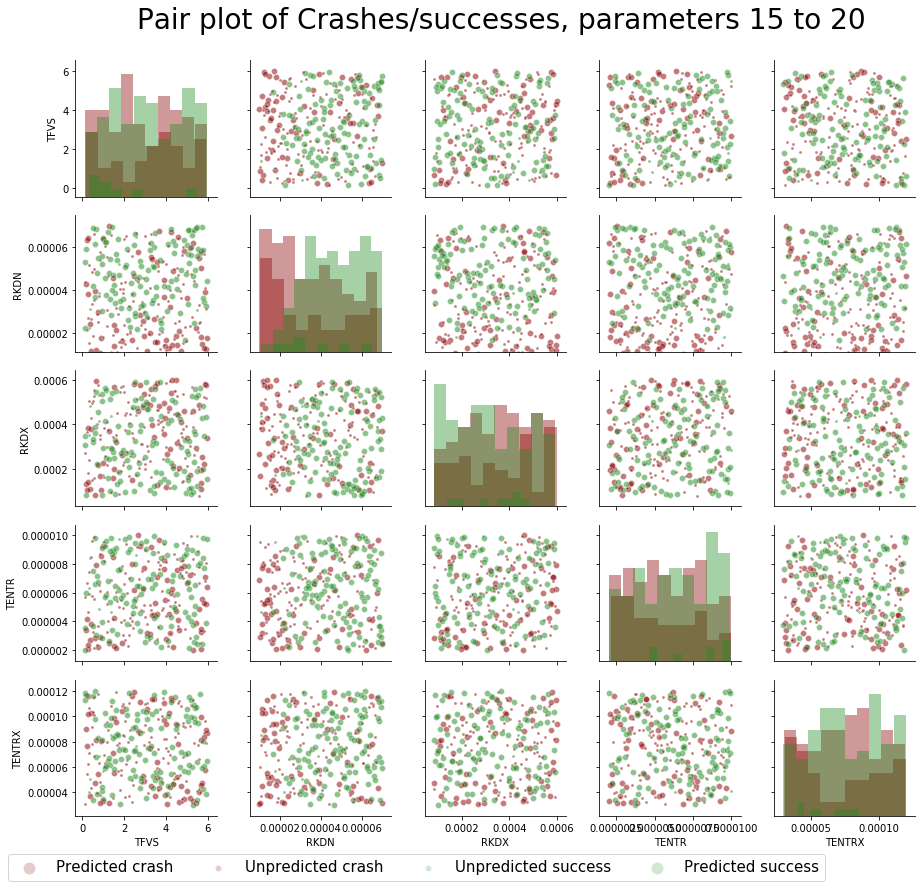

In [45]:
# Pair plot

g = sns.pairplot(inputdata[['RQICRMIN','TFVS',
 'RKDN',
 'RKDX',
 'TENTR',
 'TENTRX','Y']], hue='Y',markers=["o",".",".","o"],
            palette=('darkred','darkred','forestgreen','forestgreen'),vars=['TFVS',
 'RKDN',
 'RKDX',
 'TENTR',
 'TENTRX'], diag_kind='hist', diag_kws = {'alpha': 0.4}, plot_kws = {'alpha': 0.4})

g = g.map_offdiag(better_scatter)

handles = g._legend_data.values()
labels = g._legend_data.keys()
g._legend.remove()
g.fig.legend(handles=handles, 
             labels=['Predicted crash','Unpredicted crash','Unpredicted success','Predicted success' ], 
             loc='lower left', ncol=5, fontsize=15, markerscale=2)
g.fig.subplots_adjust(top=0.92, bottom=0.08)

# Title 
plt.suptitle('Pair plot of Crashes/successes, parameters 15 to 20', 
             size = 28)
    
plt.show()

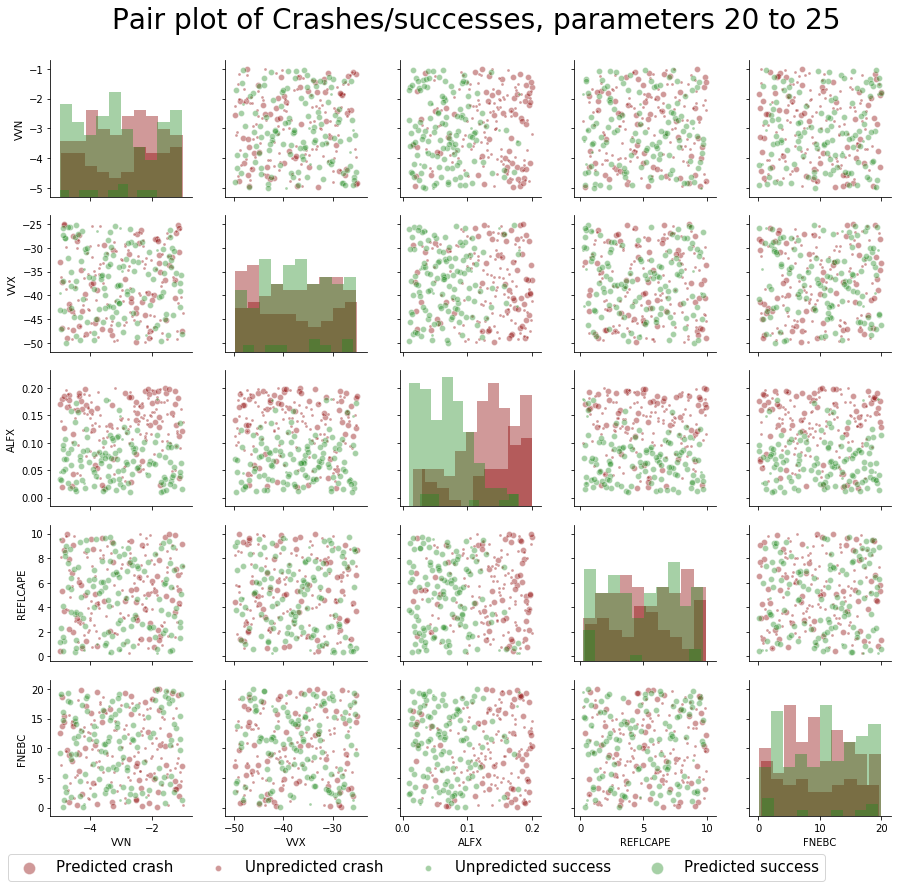

In [38]:
# Pair plot

g = sns.pairplot(inputdata[['VVN',
 'VVX',
 'ALFX',
 'REFLCAPE',
 'FNEBC','Y']], hue='Y',markers=["o",".",".","o"],
            palette=('darkred','darkred','forestgreen','forestgreen'),vars=['VVN',
 'VVX',
 'ALFX',
 'REFLCAPE',
 'FNEBC'], diag_kind='hist', diag_kws = {'alpha': 0.4}, plot_kws = {'alpha': 0.4})

handles = g._legend_data.values()
labels = g._legend_data.keys()
g._legend.remove()
g.fig.legend(handles=handles, 
             labels=['Predicted crash','Unpredicted crash','Unpredicted success','Predicted success' ], 
             loc='lower left', ncol=5, fontsize=15, markerscale=2)
g.fig.subplots_adjust(top=0.92, bottom=0.08)

# Title 
plt.suptitle('Pair plot of Crashes/successes, parameters 20 to 25', 
             size = 28)
    
plt.show()

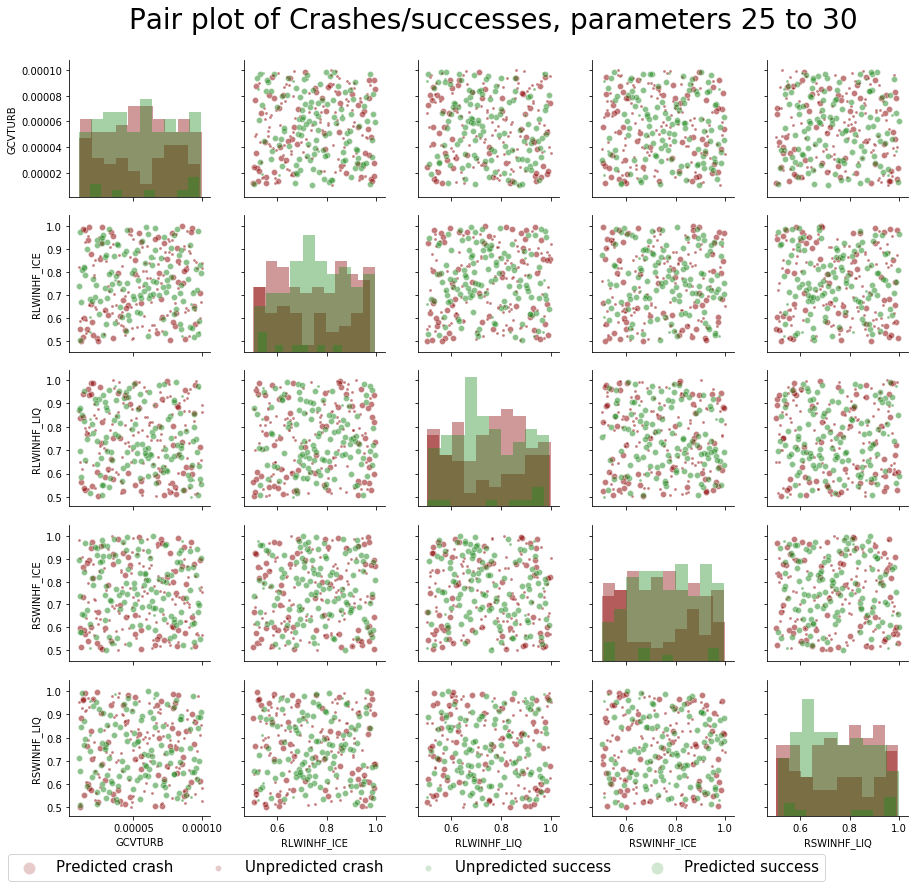

In [46]:
# Pair plot

g = sns.pairplot(inputdata[['GCVTURB',
 'RLWINHF_ICE',
 'RLWINHF_LIQ',
 'RSWINHF_ICE',
 'RSWINHF_LIQ','Y']], hue='Y',markers=["o",".",".","o"],
            palette=('darkred','darkred','forestgreen','forestgreen'),vars=['GCVTURB',
 'RLWINHF_ICE',
 'RLWINHF_LIQ',
 'RSWINHF_ICE',
 'RSWINHF_LIQ'], diag_kind='hist', diag_kws = {'alpha': 0.4}, plot_kws = {'alpha': 0.4})

g = g.map_offdiag(better_scatter)

handles = g._legend_data.values()
labels = g._legend_data.keys()
g._legend.remove()
g.fig.legend(handles=handles, 
             labels=['Predicted crash','Unpredicted crash','Unpredicted success','Predicted success' ], 
             loc='lower left', ncol=5, fontsize=15, markerscale=2)
g.fig.subplots_adjust(top=0.92, bottom=0.08)

# Title 
plt.suptitle('Pair plot of Crashes/successes, parameters 25 to 30', 
             size = 28)
    
plt.show()

### Variance decomposition : Sobol's indexes
To estimate the parameters the most important into the crash or success of the simulation. Here we use the SALib python library to perform a Sobol’ sensitivity analysis of the emultor (--> Intérêt de l'émulateur car il peut simuler rapidement !).

In [3]:
# Build an train emulator: 

import numpy as np
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

# Set the X=inputdata and y=outputdata 
X = np.load(file="inputdata_file.npy")
y_tmp = np.load(file="outputdata_file.npy")
y=y_tmp.ravel()

# split the dataset
X_train = X[0:199,:]
X_test = X[200:,:]

y_train = y[0:199]
y_test = y[200:]


# we can construct a Random Forest as follows:
clf = RandomForestClassifier(n_estimators=50,max_depth=4,max_features='sqrt', bootstrap=True)
clf = clf.fit(X_train,y_train)

In [4]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np
import pandas as pd

# Get inputdata
data = pd.read_csv("./input.csv",sep=' ')
inputdata=data.drop(['t_IDs'],axis=1)

# Get outputdata
y_tmp = np.load(file="outputdata_file.npy")
Y = y_tmp.ravel()

# Save the parameters names in a list 
param_names=list(inputdata.columns.values)

# Set the boundaries of the parameter values
bounds=[]
for i in param_names:
    bounds_tmp=[inputdata[i].min(), inputdata[i].max()]
    bounds.append(bounds_tmp)
                                                      
# Define the problem
problem = {
    'num_vars': len(param_names),
    'names': [param_names],
    'bounds' : bounds
}


# Make the Satelli sampling
param_values = saltelli.sample(problem, 1000)

# Run the emulator for all of the cases
Y = np.zeros([param_values.shape[0]])

Y = clf.predict(param_values)
    
# Perform analysis
Si = sobol.analyze(problem, Y)
print(Si['S1'])

[-4.28524291e-03  1.87335614e-02 -3.67770605e-03  3.18517958e-03
  0.00000000e+00  5.99284309e-03  5.38530623e-03  3.79271644e-03
  5.87783270e-03  9.29303307e-03  0.00000000e+00  1.10006332e-03
 -5.38530623e-03  6.48536956e-03  1.07706125e-02  4.92526467e-04
  1.25864634e-01 -1.10006332e-03  1.07706125e-02  1.98336248e-02
 -4.28524291e-03  6.97789603e-03  5.07251253e-01 -3.79271644e-03
  2.08511626e-03  4.28524291e-03 -2.69265312e-03 -2.69265312e-03
  8.57048582e-03  6.86288564e-03]


In [6]:
problem

{'num_vars': 30,
 'names': [['AKN',
   'ALPHAT',
   'ALD',
   'ALMAVE',
   'AGREF',
   'AGRE1',
   'AGRE2',
   'RAUTEFR',
   'RQLCR',
   'RAUTEFS',
   'RQICRMIN',
   'RQICRMAX',
   'TFVL',
   'TFVI',
   'TFVR',
   'TFVS',
   'RKDN',
   'RKDX',
   'TENTR',
   'TENTRX',
   'VVN',
   'VVX',
   'ALFX',
   'REFLCAPE',
   'FNEBC',
   'GCVTURB',
   'RLWINHF_ICE',
   'RLWINHF_LIQ',
   'RSWINHF_ICE',
   'RSWINHF_LIQ']],
 'bounds': [[0.0600391109910018, 0.27949724685169497],
  [0.500043397008752, 2.9998499421926703],
  [0.5029798354177419, 2.9979692896226604],
  [0.077670934866183, 29.9654089373536],
  [-0.499424082468101, -0.0104070019960481],
  [0.00233977464182911, 9.97324606931458],
  [0.032301640432948996, 9.98410209535311],
  [0.00050722207646817, 0.00996878812827248],
  [5.13821964731906e-05, 0.000998503351512598],
  [0.000503169913423481, 0.00997039737158921],
  [1.00498372209897e-08, 9.88742297073375e-07],
  [5.1708823779830705e-06, 9.98473046999231e-05],
  [0.00162669171437699, 0.19975

/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


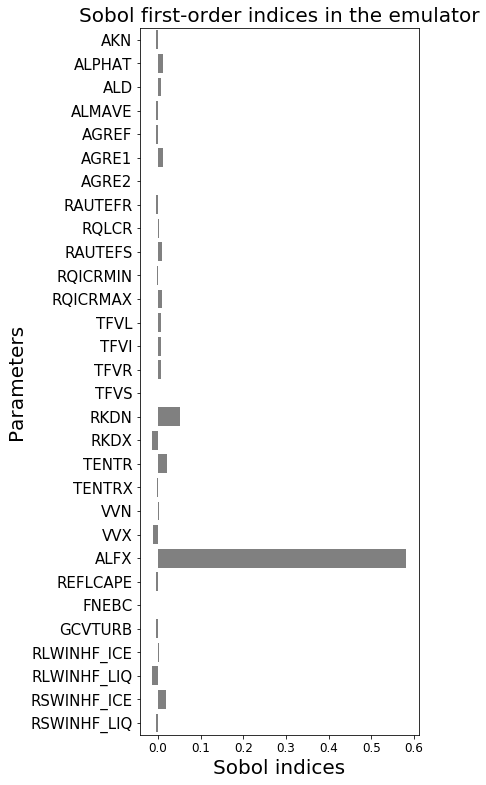

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data=pd.DataFrame()
data['Parameters']=param_names
data['Sobol1']=Si['S1']

# Plot the Sobol index to identify the most important parameters 
fig, ax = plt.subplots(figsize=(5,13))
ax = sns.barplot(x='Sobol1',y='Parameters',data=data, color='grey', orient='h', ax=ax)

plt.title('Sobol first-order indices in the emulator', fontsize=20)
plt.xlabel('Sobol indices', fontsize=20)
plt.ylabel('Parameters', fontsize=20)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=12)
    
#plt.show()

#   Enregistrer les figures ...............................................................

plt.savefig("/data/home/globc/peatier/figures/Sobol_indices.png", dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches='tight', pad_inches=0.1,
        frameon=None, metadata=None)

In [9]:
# Predict 
y_pred = clf.predict(X_test)
y_pred

# Predict Proba
y_proba_pred = clf.predict_proba(X_test)
y_proba_pred = pd.DataFrame(y_proba_pred)
y_proba_pred['Pertubations']=range(1,101,1)
y_proba_pred = y_proba_pred.rename(columns={0: 'Crash', 1:'Success'})
y_proba_pred

# Appel de la fonction confusion matrix : plot the skill of the emulator
#classes=['Crash', 'Success']

#plot_confusion_matrix(y_test, y_pred, classes, normalize=False, 
#                      title='n_estimators=50, max_depth=4, max_features: sqrt')

# Enregistrer la figure .................................

#plt.savefig("/data/home/globc/peatier/figures/Confusion_Matrice.png", dpi=None,
#        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

,Crash,Success,Pertubations
0,0.345821,0.654179,1
1,0.697695,0.302305,2
2,0.548645,0.451355,3
3,0.798027,0.201973,4
4,0.498267,0.501733,5
...,...,...,...
95,0.437197,0.562803,96
96,0.752262,0.247738,97
97,0.526984,0.473016,98
98,0.335531,0.664469,99


In [10]:
# Create the Y in the inputdata, using classification between predicted and trus y 
import numpy as np
import pandas as pd

# Create the well-sized class and proba prediction dataframe to me compared with inputdata
y_pred_crash=pd.DataFrame(y_pred)
y_pred_crash = y_pred_crash.rename(columns={0: 'class'})

y_pred=pd.DataFrame()
y_pred['class']=y_pred_crash['class']
y_pred['proba']=range(1,101,1)

i=0
while i<len(y_proba_pred):
    tmp=y_proba_pred.iloc[i]
    if tmp['Crash']>tmp['Success']:
        y_pred['proba'].iloc[i]=tmp['Crash']
    else :
        y_pred['proba'].iloc[i]=tmp['Success']
    i = ( i + 1 )

y_pred['Perturbations']=range(1,101,1)
#y_pred

y_PRED=pd.DataFrame()
y_PRED['class']=range(1,201,1)
y_PRED['proba']=range(1,201,1)

frames=[y_PRED,y_pred]
pred = pd.concat(frames,ignore_index=True)
pred.iloc[0:199]=np.NaN
#pred

/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [11]:
# Create the Y in the inputdata, using classification between predicted and trus y 
import numpy as np
import pandas as pd


# Create the Y in the inputdata, using classification between predicted and true y 

data = pd.read_csv("./input.csv",sep=' ')
inputdata=data.drop(['t_IDs'],axis=1)

# Set the X=inputdata and y=outputdata 
y_tmp = np.load(file="outputdata_file.npy")
y_true=y_tmp.ravel()
#y_true
inputdata['y_true']=y_true
inputdata['y_pred_class']=pred['class']
inputdata['y_pred_proba']=pred['proba']

# Loop to construct new column gathering true and predicted data
Y=[]
i=0
N=len(inputdata)
while i<N:
    tmp=inputdata.iloc[i]
    if tmp['y_true']==0:
        if tmp['y_pred_class']==0:
            Y.append(0.0)
        else :
            Y.append(0.1)
    else :
        if tmp['y_pred_class']==0:
            Y.append(1.0)
        else :
            Y.append(1.1)
    i=(i+1)

inputdata['Y']=Y
            
# Save the parameters names in a list 
param_names=list(inputdata.columns.values)
#param_names

inputdata

,AKN,ALPHAT,ALD,ALMAVE,AGREF,AGRE1,AGRE2,RAUTEFR,RQLCR,RAUTEFS,...,FNEBC,GCVTURB,RLWINHF_ICE,RLWINHF_LIQ,RSWINHF_ICE,RSWINHF_LIQ,y_true,y_pred_class,y_pred_proba,Y
0,0.175049,1.488544,1.449805,15.532379,-0.238847,2.270914,5.235486,0.006996,0.000441,0.003952,...,14.254849,0.000063,0.864952,0.677901,0.768799,0.744990,1,NaN,NaN,1.1
1,0.121135,0.670766,1.378806,17.467465,-0.225716,3.088520,6.590831,0.003974,0.000527,0.005401,...,8.218562,0.000053,0.782406,0.777564,0.721309,0.837602,0,NaN,NaN,0.1
2,0.167680,1.880158,1.973222,14.357632,-0.250957,4.865664,7.353332,0.006406,0.000642,0.004999,...,12.882991,0.000074,0.802851,0.616178,0.800514,0.733552,1,NaN,NaN,1.1
3,0.173487,2.086636,2.070605,21.338777,-0.278889,2.642393,4.222709,0.008153,0.000210,0.006296,...,3.646718,0.000077,0.779812,0.660804,0.648204,0.738744,1,NaN,NaN,1.1
4,0.160021,2.370838,1.835850,15.060141,-0.301109,5.391311,3.782260,0.003023,0.000394,0.003919,...,8.104176,0.000077,0.906631,0.754324,0.828823,0.746475,1,NaN,NaN,1.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.163872,2.736582,0.851156,26.111547,-0.155597,1.131551,2.797022,0.006913,0.000169,0.002175,...,0.168907,0.000098,0.829398,0.577758,0.549168,0.888836,1,1.0,0.562803,1.1
296,0.274858,1.419111,2.514090,25.663451,-0.411510,3.485938,6.203646,0.007755,0.000355,0.005669,...,9.611947,0.000027,0.995207,0.821871,0.504201,0.686163,0,0.0,0.752262,0.0
297,0.197926,2.972243,1.692315,21.918375,-0.418075,0.002340,7.499519,0.001215,0.000873,0.003210,...,16.819777,0.000058,0.608357,0.970929,0.760589,0.571225,0,0.0,0.526984,0.0
298,0.159194,2.766423,0.502980,17.348568,-0.395271,8.944777,9.659447,0.009158,0.000123,0.005501,...,3.969082,0.000028,0.924979,0.549787,0.982908,0.775761,1,1.0,0.664469,1.1


In [12]:
# Definition d'une fonction pour un meilleur scattering (problème d'échelle sur l'axe y dans sns.pairplot)
def better_scatter(x, y, **kwargs):
    sns.scatterplot(x, y, **kwargs, alpha=0.2)
    margin = (max(y) - min(y)) * 0.1
    plt.ylim(min(y) - margin, max(y) + margin)

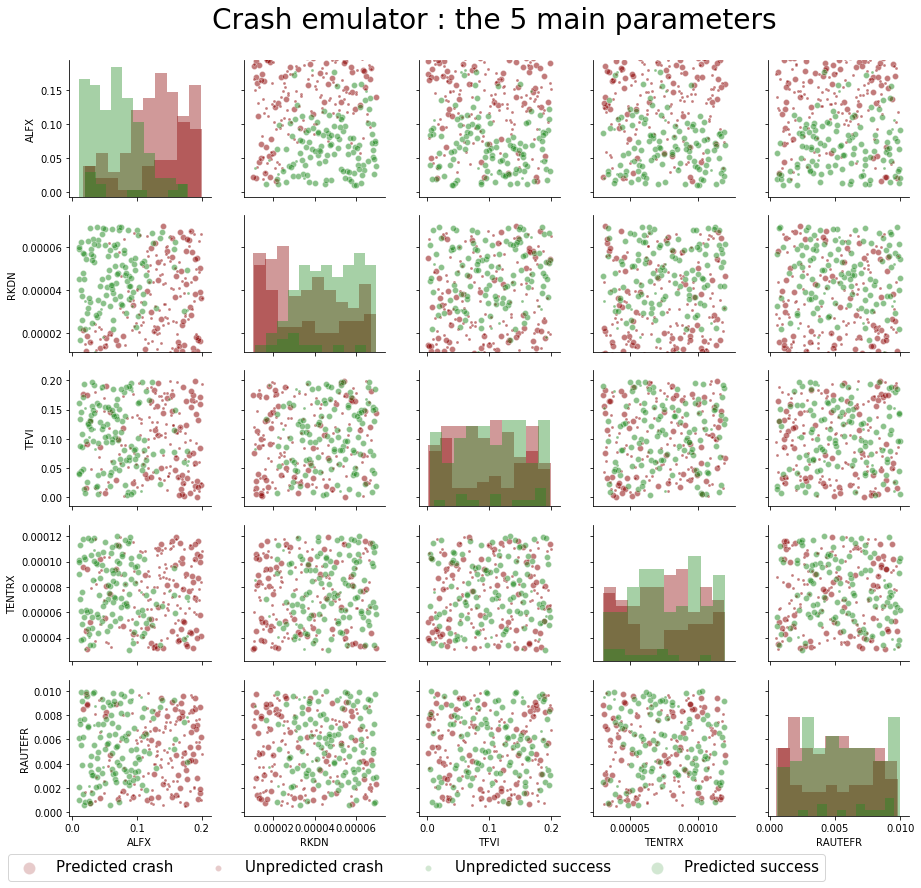

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Pair plot of parameters with the highest Sobol index

g = sns.pairplot(inputdata[['ALFX',
 'RKDN',
 'TFVI',
 'TENTRX',
 'RAUTEFR','Y']], hue='Y',markers=["o",".",".","o"],
            palette=('darkred','darkred','forestgreen','forestgreen'),vars=['ALFX',
 'RKDN',
 'TFVI',
 'TENTRX',
 'RAUTEFR'], diag_kind='hist', diag_kws = {'alpha': 0.4}, plot_kws = {'alpha': 0.4})

g = g.map_offdiag(better_scatter)

handles = g._legend_data.values()
labels = g._legend_data.keys()
g._legend.remove()
g.fig.legend(handles=handles, 
             labels=['Predicted crash','Unpredicted crash','Unpredicted success','Predicted success' ], 
             loc='lower left', ncol=5, fontsize=15, markerscale=2)
g.fig.subplots_adjust(top=0.92, bottom=0.08)

# Title 
plt.suptitle('Crash emulator : the 5 main parameters', 
             size = 28)

#   Enregistrer les figures ...............................................................

g.savefig("/data/home/globc/peatier/figures/Pairplot_HighSoboIndices.png", dpi=None,
        orientation='portrait', bbox_inches='tight', pad_inches=0.1,
        frameon=None, metadata=None)

# Show the graph ..................................

plt.show()